In [1]:
from keras.models import Sequential 
from keras.layers import Dense,Conv2D,MaxPooling2D,UpSampling2D
from keras import Input, Model
from keras.datasets import mnist
from keras import backend as k
from keras.layers import Lambda
from tensorflow.keras.metrics import binary_crossentropy
import keras

from extra_keras_datasets import kmnist

import numpy as np
import matplotlib.pyplot as plt
import random

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [3]:
batch_size, n_epoch = 100, 150
latent_dim = 2

input_img = Input(shape=(x_train[0].shape))
x = Dense(200, activation='relu')(input_img)
x= Dense(100, activation='relu')(x)
x = Dense(30, activation='relu')(x)

mu = Dense(latent_dim)(x)
log_var = Dense(latent_dim)(x)

encoder = Model(input_img, mu, name='Encoder')
encoder.summary()

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 200)               157000    
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 dense_2 (Dense)             (None, 30)                3030      
                                                                 
 dense_3 (Dense)             (None, 2)                 62        
                                                                 
Total params: 180,192
Trainable params: 180,192
Non-trainable params: 0
_________________________________________________________________


In [4]:
def sampling(args):
    mu, log_var = args
    eps = k.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
    return mu + k.exp(log_var) * eps

z = Lambda(sampling, output_shape=(latent_dim,))([mu, log_var])

In [5]:
z_decoder1 = Dense(30, activation='relu')
z_decoder2 = Dense(100, activation='relu')
z_decoder3 = Dense(200, activation='relu')
y_decoder = Dense((x_train[0].shape[0]), activation='sigmoid')

z_decoded = z_decoder1(z)
z_decoded = z_decoder2(z_decoded)
z_decoded = z_decoder3(z_decoded)
y = y_decoder(z_decoded)

In [6]:
reconstruction_loss = binary_crossentropy(input_img, y) * x_train[0].shape
kl_loss = 0.5 * k.sum(k.square(mu) + k.exp(log_var) - log_var - 1, axis = -1)
vae_loss = reconstruction_loss + kl_loss

vae = Model(input_img, y)
vae.add_loss(vae_loss)

vae.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 200)          157000      ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 100)          20100       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 30)           3030        ['dense_1[0][0]']                
                                                                                              

In [7]:
vae.compile(optimizer='rmsprop')
history = vae.fit(x_train, shuffle=True, epochs=n_epoch, batch_size=batch_size, validation_data=(x_test, None), verbose=1)

Epoch 1/150
600/600 [==============================] - 9s 11ms/step - loss: 191.5655 - val_loss: 168.6778
Epoch 2/150
600/600 [==============================] - 6s 10ms/step - loss: 163.4272 - val_loss: 157.7050
Epoch 3/150
600/600 [==============================] - 5s 9ms/step - loss: 155.4590 - val_loss: 152.2686
Epoch 4/150
600/600 [==============================] - 5s 9ms/step - loss: 150.9104 - val_loss: 148.3452
Epoch 5/150
600/600 [==============================] - 6s 9ms/step - loss: 148.2709 - val_loss: 146.9825
Epoch 6/150
600/600 [==============================] - 5s 9ms/step - loss: 146.3205 - val_loss: 145.2133
Epoch 7/150
600/600 [==============================] - 5s 9ms/step - loss: 144.6548 - val_loss: 143.9909
Epoch 8/150
600/600 [==============================] - 5s 8ms/step - loss: 143.3504 - val_loss: 142.7278
Epoch 9/150
600/600 [==============================] - 4s 7ms/step - loss: 142.3866 - val_loss: 141.8740
Epoch 10/150
600/600 [==============================]

600/600 [==============================] - 4s 6ms/step - loss: 137.5426 - val_loss: 138.9198
Epoch 79/150
600/600 [==============================] - 4s 6ms/step - loss: 137.9469 - val_loss: 139.0475
Epoch 80/150
600/600 [==============================] - 4s 6ms/step - loss: 138.0158 - val_loss: 139.8640
Epoch 81/150
600/600 [==============================] - 4s 6ms/step - loss: 138.7737 - val_loss: 139.6805
Epoch 82/150
600/600 [==============================] - 4s 6ms/step - loss: 137.9188 - val_loss: 139.4416
Epoch 83/150
600/600 [==============================] - 4s 6ms/step - loss: 137.9923 - val_loss: 138.3476
Epoch 84/150
600/600 [==============================] - 4s 6ms/step - loss: 137.5796 - val_loss: 138.0300
Epoch 85/150
600/600 [==============================] - 4s 6ms/step - loss: 138.1203 - val_loss: 138.0664
Epoch 86/150
600/600 [==============================] - 4s 6ms/step - loss: 137.8425 - val_loss: 141.1148
Epoch 87/150
600/600 [==============================] - 4s 

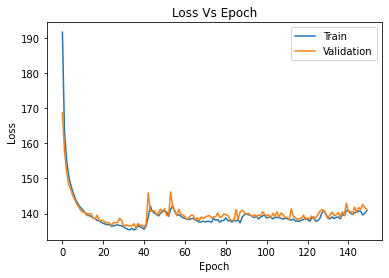

In [8]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

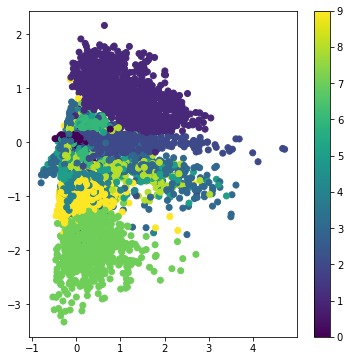

In [9]:
x_te_latent = encoder.predict(x_test, batch_size=256)
plt.figure(figsize=(6, 6))
plt.scatter(x_te_latent[:, 0], x_te_latent[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [10]:
decoded_img = vae.predict(x_test, batch_size=batch_size)

Orignal Image:


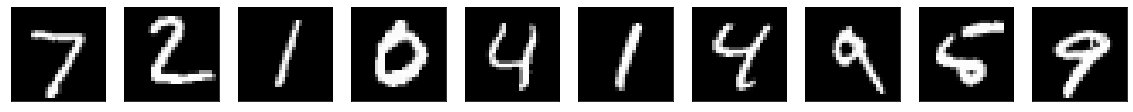

Reconstructed Image:


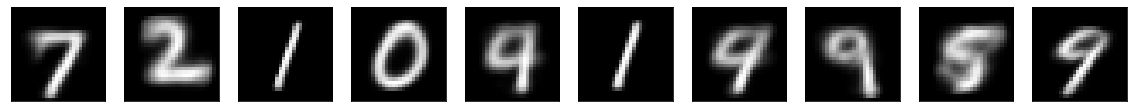

In [11]:
n = 10

print('Orignal Image:')
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


print('Reconstructed Image:')
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_img[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [12]:
decoder_input = Input(shape=(latent_dim,))
_z_decoded = z_decoder1(decoder_input)
_z_decoded = z_decoder2(_z_decoded)
_z_decoded = z_decoder3(_z_decoded)
_y = y_decoder(_z_decoded)
generator = Model(decoder_input, _y, name='Decoder')
generator.summary()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_5 (Dense)             multiple                  90        
                                                                 
 dense_6 (Dense)             multiple                  3100      
                                                                 
 dense_7 (Dense)             multiple                  20200     
                                                                 
 dense_8 (Dense)             multiple                  157584    
                                                                 
Total params: 180,974
Trainable params: 180,974
Non-trainable params: 0
_________________________________________________________________


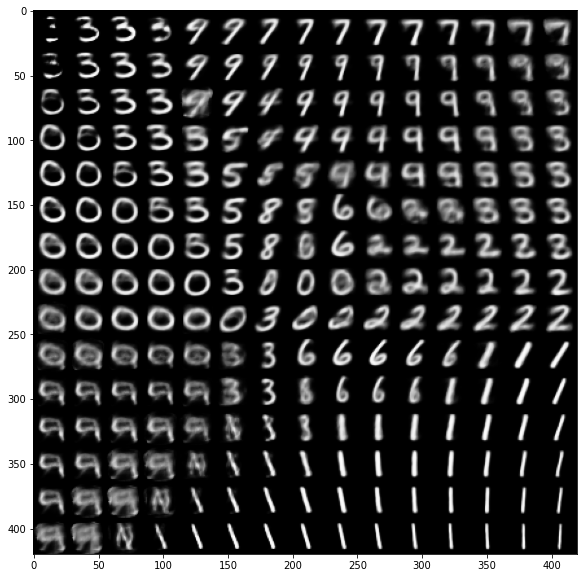

In [14]:
from scipy.stats import norm

n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) 
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()